In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [4]:

customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Def: `preprocess_data`

### **Purpose**:
Preprocess customer and transaction data to generate features for clustering.

### **Key Steps**:

1. **Convert Date Columns**:
   - Convert `SignupDate` and `TransactionDate` to datetime format for easier manipulation.

2. **Transaction Features**:
   - Calculate aggregated features for each customer:
     - Total transactions (`total_transactions`).
     - Total, average, and standard deviation of transaction value (`total_spend`, `avg_transaction_value`, `std_transaction_value`).
     - Total and average quantity purchased (`total_quantity`, `avg_quantity`).
     - Active days (number of days between the first and last transaction).

3. **Recency**:
   - Calculate recency (days since the last transaction).

4. **Customer Features**:
   - Create one-hot encoded features for customer region (`Region`).

5. **Final Features**:
   - Merge the customer features with transaction features.
   - Fill missing values with zeros.

6. **Return**:
   - Return the features for clustering (`features_for_clustering`) and the `CustomerID` column.


In [5]:
def preprocess_data(customers_df, transactions_df):

    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])


    transaction_features = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean', 'std'],
        'Quantity': ['sum', 'mean'],
        'TransactionDate': lambda x: (x.max() - x.min()).days
    }).fillna(0)


    transaction_features.columns = [
        'total_transactions',
        'total_spend',
        'avg_transaction_value',
        'std_transaction_value',
        'total_quantity',
        'avg_quantity',
        'active_days'
    ]


    last_transaction_date = transactions_df.groupby('CustomerID')['TransactionDate'].max()
    max_date = transactions_df['TransactionDate'].max()
    recency = (max_date - last_transaction_date).dt.days
    transaction_features['recency'] = recency


    customer_features = pd.get_dummies(customers_df[['CustomerID', 'Region']], columns=['Region'])


    final_features = customer_features.merge(
        transaction_features,
        left_on='CustomerID',
        right_index=True,
        how='left'
    ).fillna(0)


    customer_ids = final_features['CustomerID']
    features_for_clustering = final_features.drop('CustomerID', axis=1)

    return features_for_clustering, customer_ids


# Python Def Function: `create_advanced_features`

### **Purpose**:
Generate advanced features for customer and transaction data.

### **Key Steps**:

1. **Date Conversion**:
   - Convert `SignupDate` and `TransactionDate` to datetime format.

2. **Transaction Features**:
   - Aggregate features like:
     - Total transactions, spend, and quantities.
     - Mean, std, and median values for transaction amount and price.
     - Active days and transaction count.

3. **Additional Features**:
   - Calculate:
     - Purchase frequency.
     - Average basket size.
     - Customer value score.
     - Transaction consistency.

4. **Recency**:
   - Calculate recency (days since last transaction).

5. **Customer Tenure**:
   - Calculate customer tenure (days since signup).

6. **Final Merge**:
   - Merge customer features (Region, Tenure) with transaction features.
   - Return the final feature set.


In [6]:
def create_advanced_features(customers_df, transactions_df):

    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])


    transaction_features = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean', 'std', 'median'],
        'Quantity': ['sum', 'mean', 'std'],
        'Price': ['mean', 'std'],
        'TransactionDate': [
            lambda x: (x.max() - x.min()).days,
            'count'
        ]
    }).fillna(0)


    transaction_features.columns = [
        'total_transactions',
        'total_spend',
        'avg_transaction_value',
        'std_transaction_value',
        'median_transaction_value',
        'total_quantity',
        'avg_quantity',
        'std_quantity',
        'avg_price',
        'std_price',
        'active_days',
        'transaction_count'
    ]


    transaction_features['purchase_frequency'] = (
        transaction_features['transaction_count'] /
        np.maximum(transaction_features['active_days'], 1)
    )


    transaction_features['avg_basket_size'] = (
        transaction_features['total_quantity'] /
        transaction_features['total_transactions']
    ).fillna(0)


    transaction_features['customer_value_score'] = (
        transaction_features['total_spend'] *
        transaction_features['purchase_frequency']
    )


    transaction_features['transaction_consistency'] = (
        1 / (transaction_features['std_transaction_value'] + 1)
    )


    last_transaction_date = transactions_df.groupby('CustomerID')['TransactionDate'].max()
    max_date = transactions_df['TransactionDate'].max()
    recency = (max_date - last_transaction_date).dt.days
    transaction_features['recency'] = recency


    max_date = customers_df['SignupDate'].max()
    customers_df['tenure'] = (max_date - customers_df['SignupDate']).dt.days


    customer_features = pd.get_dummies(customers_df[['CustomerID', 'Region', 'tenure']], columns=['Region'])
    final_features = customer_features.merge(
        transaction_features,
        left_on='CustomerID',
        right_index=True,
        how='left'
    ).fillna(0)

    return final_features

In [7]:
def optimize_clusters(features, max_clusters=10):
    results = []

    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(features)

        db_index = davies_bouldin_score(features, labels)
        silhouette = silhouette_score(features, labels)
        calinski = calinski_harabasz_score(features, labels)

        results.append({
            'n_clusters': n_clusters,
            'db_index': db_index,
            'silhouette': silhouette,
            'calinski': calinski
        })

    results_df = pd.DataFrame(results)


    normalized_scores = (results_df - results_df.mean()) / results_df.std()


    normalized_scores['combined_score'] = (
        -normalized_scores['db_index'] +
        normalized_scores['silhouette'] +
        normalized_scores['calinski']
    ) / 3

    optimal_clusters = results_df.iloc[normalized_scores['combined_score'].argmax()]['n_clusters']

    return int(optimal_clusters), results_df

In [8]:
def plot_clustering_results(features, labels, customer_ids):

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)


    plot_df = pd.DataFrame({
        'CustomerID': customer_ids,
        'PC1': features_2d[:, 0],
        'PC2': features_2d[:, 1],
        'Cluster': labels
    })


    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', palette='deep')
    plt.title('Customer Segments Visualization (PCA)')
    plt.savefig('cluster_visualization.png')
    plt.close()

    return plot_df

In [9]:
def perform_optimized_clustering(customers_df, transactions_df):

    final_features = create_advanced_features(customers_df, transactions_df)
    customer_ids = final_features['CustomerID']
    features_for_clustering = final_features.drop('CustomerID', axis=1)


    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(features_for_clustering)


    optimal_clusters, metrics_df = optimize_clusters(scaled_features)


    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)


    final_db_index = davies_bouldin_score(scaled_features, cluster_labels)
    final_silhouette = silhouette_score(scaled_features, cluster_labels)
    final_calinski = calinski_harabasz_score(scaled_features, cluster_labels)


    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(scaled_features)


    plot_df = pd.DataFrame({
        'CustomerID': customer_ids,
        'PC1': features_2d[:, 0],
        'PC2': features_2d[:, 1],
        'Cluster': cluster_labels
    })


    plt.figure(figsize=(12, 8))


    sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', palette='deep')
    plt.title(f'Customer Segments (n={optimal_clusters}, DB Index={final_db_index:.4f})')
    plt.savefig('cluster_visualization.png')
    plt.close()


    cluster_profiles = pd.DataFrame({
        'Cluster': cluster_labels,
        'CustomerID': customer_ids
    })

    cluster_summary = cluster_profiles['Cluster'].value_counts().sort_index()

    return {
        'optimal_clusters': optimal_clusters,
        'db_index': final_db_index,
        'silhouette_score': final_silhouette,
        'calinski_score': final_calinski,
        'cluster_labels': cluster_labels,
        'plot_df': plot_df,
        'metrics_df': metrics_df,
        'cluster_summary': cluster_summary
    }


In [10]:

results = perform_optimized_clustering(customers_df, transactions_df)

print(f"Number of clusters: {results['optimal_clusters']}")
print(f"\nDavies-Bouldin Index: {results['db_index']:.4f}")
print(f"Silhouette Score: {results['silhouette_score']:.4f}")
print(f"Calinski-Harabasz Score: {results['calinski_score']:.4f}")

print("\nCluster sizes:")
print(results['cluster_summary'])

print("\nClustering metrics across different k:")
print(results['metrics_df'])

Number of clusters: 2

Davies-Bouldin Index: 0.0113
Silhouette Score: 0.9928
Calinski-Harabasz Score: 323155.9073

Cluster sizes:
Cluster
0    188
1     12
Name: count, dtype: int64

Clustering metrics across different k:
   n_clusters  db_index  silhouette       calinski
0           2  0.011323    0.992803  323155.907309
1           3  0.095445    0.810277  193274.505410
2           4  0.801754    0.310087  154277.537196
3           5  0.811870    0.327056  137493.083827
4           6  0.975925    0.301229  121929.656062
5           7  1.010922    0.246756  113162.335634
6           8  1.158638    0.198399   99794.098167
7           9  0.941443    0.209512  100288.928836
8          10  1.068292    0.200832   93699.633576


In [11]:
def create_cluster_visualizations(scaled_features, cluster_labels, customer_ids, original_features, save_prefix='cluster'):
    """
    Create and save multiple visualization plots for cluster analysis

    Parameters:
    scaled_features: scaled features used for clustering
    cluster_labels: cluster assignments
    customer_ids: array of customer IDs
    original_features: original feature DataFrame before scaling
    save_prefix: prefix for saved plot files
    """


    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(scaled_features)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                         c=cluster_labels, cmap='viridis',
                         alpha=0.6, s=100)
    plt.title('Customer Segments - PCA Visualization', fontsize=14, pad=20)
    plt.xlabel(f'First Principal Component\n(Explains {pca.explained_variance_ratio_[0]:.1%} of variance)')
    plt.ylabel(f'Second Principal Component\n(Explains {pca.explained_variance_ratio_[1]:.1%} of variance)')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{save_prefix}_pca.png', dpi=300, bbox_inches='tight')
    plt.close()


    plt.figure(figsize=(10, 6))
    cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
    sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis')
    plt.title('Cluster Size Distribution', fontsize=14, pad=20)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Customers')
    for i, v in enumerate(cluster_sizes.values):
        plt.text(i, v, str(v), ha='center', va='bottom')
    plt.savefig(f'{save_prefix}_sizes.png', dpi=300, bbox_inches='tight')
    plt.close()


    plt.figure(figsize=(15, 8))
    cluster_means = pd.DataFrame(scaled_features, columns=original_features.columns).groupby(cluster_labels).mean()
    sns.heatmap(cluster_means, cmap='RdYlBu_r', center=0, annot=True, fmt='.2f',
                cbar_kws={'label': 'Standardized Value'})
    plt.title('Feature Importance by Cluster', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_features.png', dpi=300, bbox_inches='tight')
    plt.close()


    from sklearn.metrics import silhouette_samples

    plt.figure(figsize=(10, len(np.unique(cluster_labels)) * 1.5))
    silhouette_vals = silhouette_samples(scaled_features, cluster_labels)
    y_lower = 10

    for i in range(len(np.unique(cluster_labels))):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()
        size_cluster_i = len(cluster_silhouette_vals)
        y_upper = y_lower + size_cluster_i

        color = plt.cm.viridis(float(i) / len(np.unique(cluster_labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
        y_lower = y_upper + 10

    plt.title('Silhouette Plot of Clusters', fontsize=14, pad=20)
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Cluster')
    plt.axvline(x=silhouette_vals.mean(), color="red", linestyle="--",
                label=f'Average Silhouette: {silhouette_vals.mean():.3f}')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_silhouette.png', dpi=300, bbox_inches='tight')
    plt.close()


    from mpl_toolkits.mplot3d import Axes3D

    pca_3d = PCA(n_components=3)
    features_3d = pca_3d.fit_transform(scaled_features)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2],
                        c=cluster_labels, cmap='viridis', s=50, alpha=0.6)

    ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
    ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')
    plt.title('3D PCA Visualization of Clusters', fontsize=14, pad=20)
    plt.colorbar(scatter, label='Cluster')
    plt.savefig(f'{save_prefix}_pca_3d.png', dpi=300, bbox_inches='tight')
    plt.close()


In [12]:

final_features = create_advanced_features(customers_df, transactions_df)
features_for_clustering = final_features.drop('CustomerID', axis=1)


scaler = RobustScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

create_cluster_visualizations(
    scaled_features=scaled_features,
    cluster_labels=results['cluster_labels'],
    customer_ids=final_features['CustomerID'],
    original_features=features_for_clustering,
    save_prefix='customer_clusters'
)

<ipython-input-11-095c43bacc20>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis')


## Creating the combined Graph Here For analysis

<ipython-input-13-b3ed47856919>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis', ax=ax2)


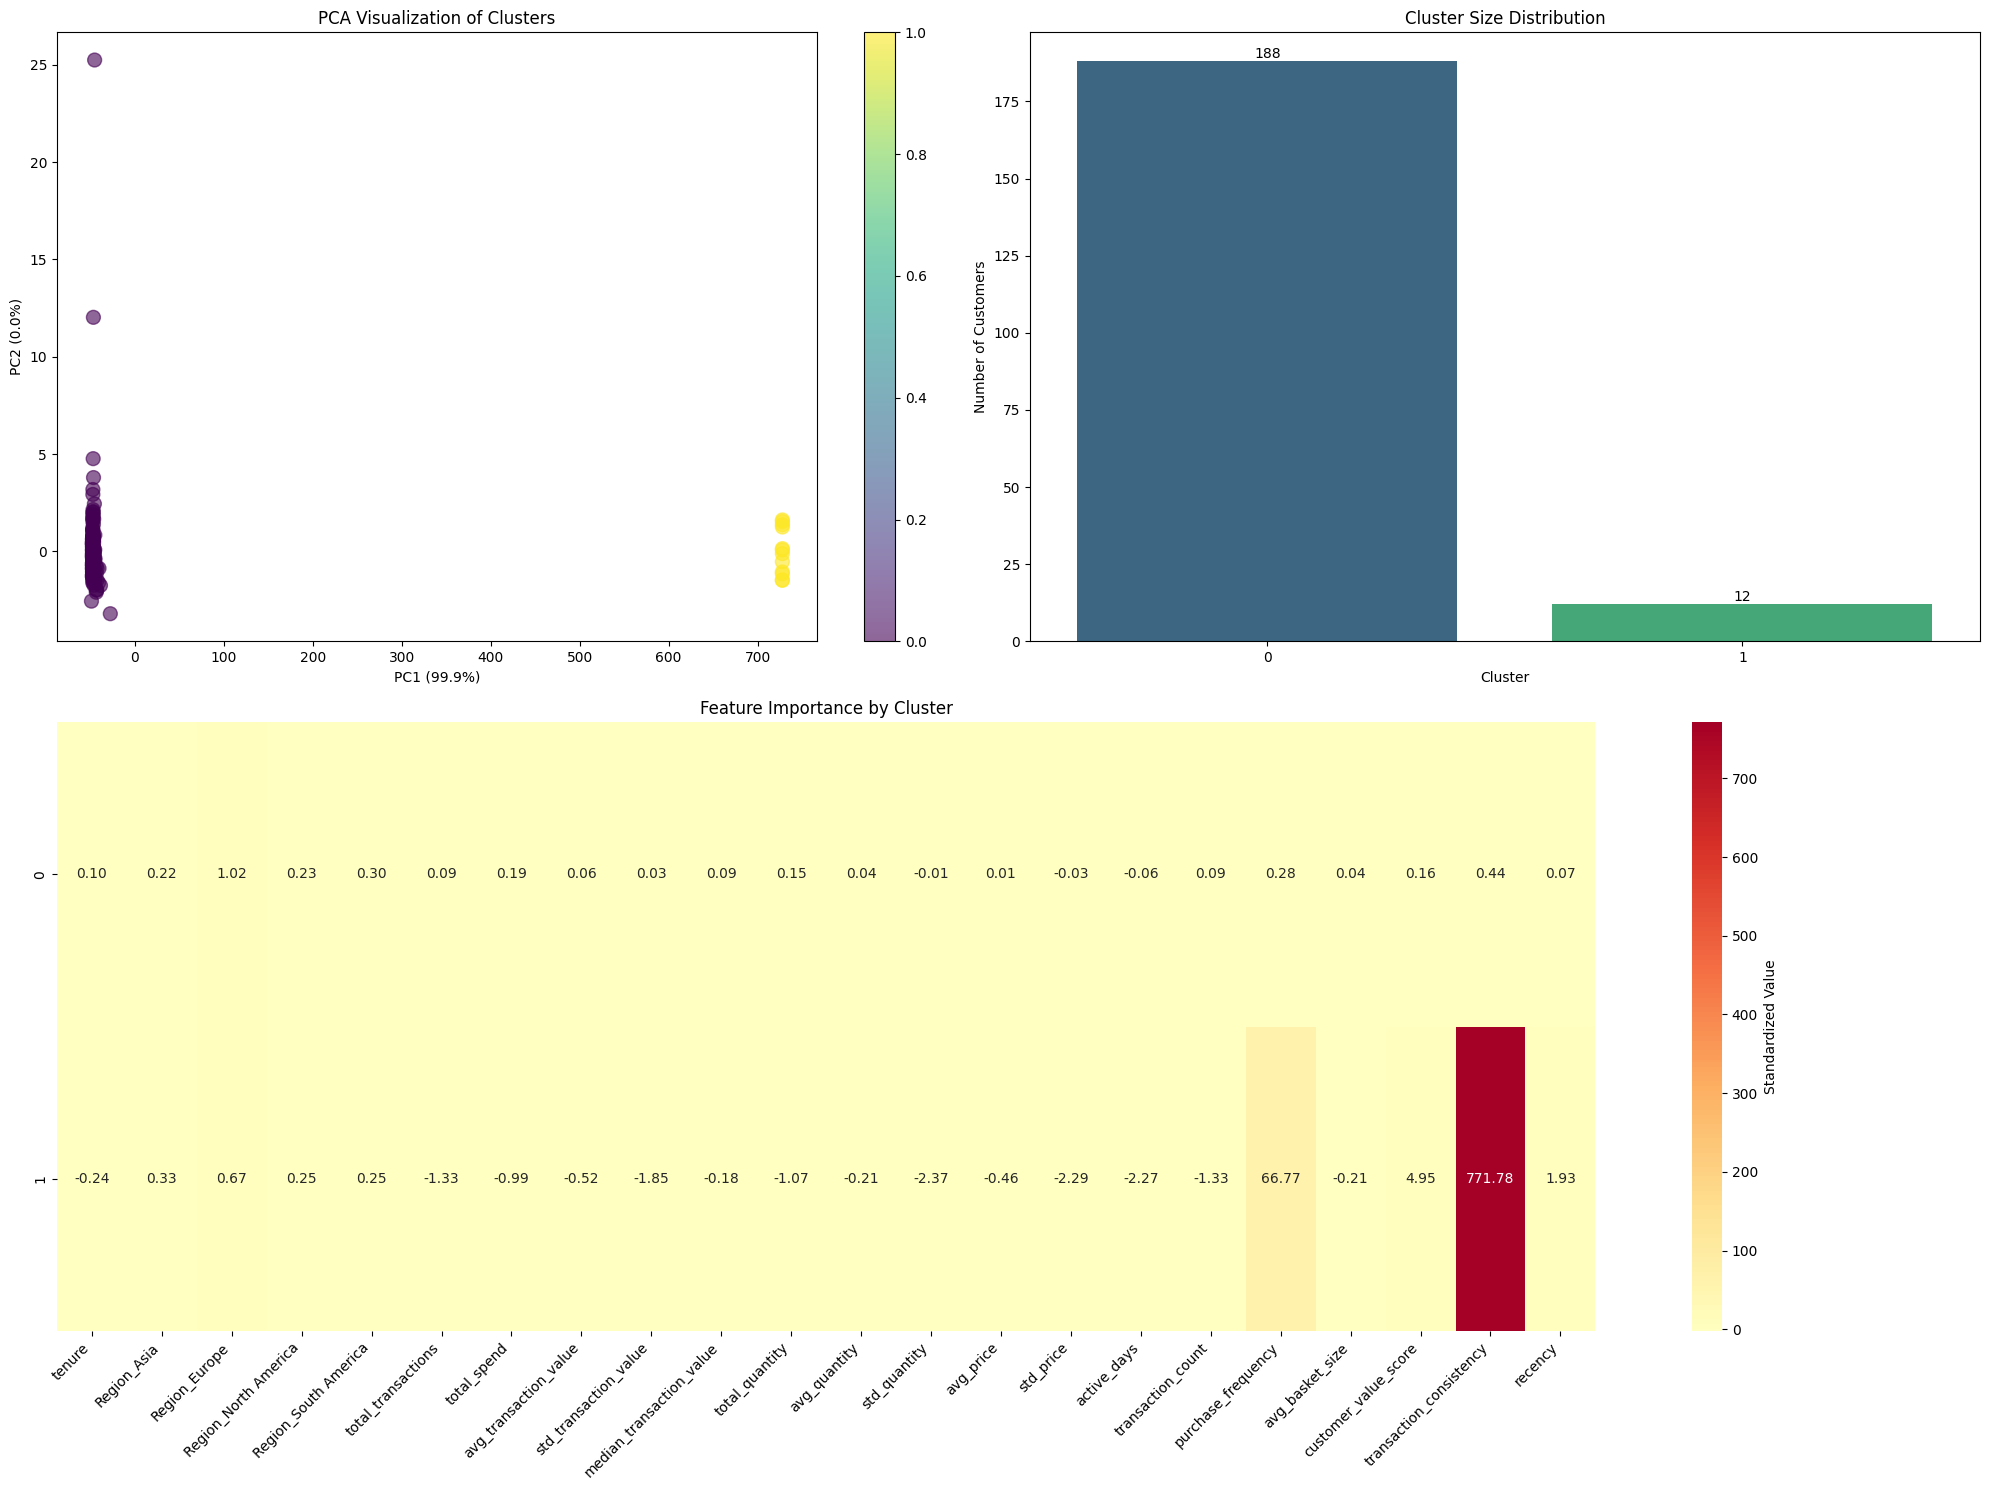

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

def create_combined_visualization(scaled_features, cluster_labels, original_features):

    fig = plt.figure(figsize=(20, 15))


    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(scaled_features)

    ax1 = plt.subplot(2, 2, 1)
    scatter = ax1.scatter(features_2d[:, 0], features_2d[:, 1],
                         c=cluster_labels, cmap='viridis',
                         alpha=0.6, s=100)
    ax1.set_title('PCA Visualization of Clusters', fontsize=12)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.colorbar(scatter, ax=ax1)


    ax2 = plt.subplot(2, 2, 2)
    cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
    sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis', ax=ax2)
    ax2.set_title('Cluster Size Distribution', fontsize=12)
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Number of Customers')
    for i, v in enumerate(cluster_sizes.values):
        ax2.text(i, v, str(v), ha='center', va='bottom')


    ax3 = plt.subplot(2, 1, 2)
    cluster_means = pd.DataFrame(scaled_features, columns=original_features.columns).groupby(cluster_labels).mean()
    sns.heatmap(cluster_means, cmap='RdYlBu_r', center=0, annot=True, fmt='.2f',
                cbar_kws={'label': 'Standardized Value'}, ax=ax3)
    ax3.set_title('Feature Importance by Cluster', fontsize=12)
    plt.xticks(rotation=45, ha='right')


    plt.tight_layout()
    plt.show()


results = perform_optimized_clustering(customers_df, transactions_df)


final_features = create_advanced_features(customers_df, transactions_df)
features_for_clustering = final_features.drop('CustomerID', axis=1)
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features_for_clustering)


create_combined_visualization(
    scaled_features=scaled_features,
    cluster_labels=results['cluster_labels'],
    original_features=features_for_clustering
)